# Rock Paper Scissor - Multiclass Classification

In [1]:
%load_ext autoreload 
%autoreload 2

## Install `tfutils`


In [2]:
!pip install -e /content/drive/MyDrive/projects/tfutils

Obtaining file:///content/drive/MyDrive/projects/tfutils
  Running setup.py develop for tfutils


## Some imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tfutils
import glob

## Download Data

### Train Data

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps-train.zip

--2021-07-23 12:35:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 142.251.8.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps-train.zip’

/tmp/rps-train.zip  100%[===================>] 191.38M  27.4MB/s    in 7.0s    

2021-07-23 12:35:54 (27.4 MB/s) - ‘/tmp/rps-train.zip’ saved [200682221/200682221]



### Test Data


In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test.zip

--2021-07-23 12:35:54--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp/rps-test.zip’

/tmp/rps-test.zip   100%[===================>]  28.15M  22.5MB/s    in 1.2s    

2021-07-23 12:35:56 (22.5 MB/s) - ‘/tmp/rps-test.zip’ saved [29516758/29516758]



In [5]:
import os
import zipfile


for subset in ['train', 'test']:
    local_zip = f'/tmp/rps-{subset}.zip'
    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall(f'/tmp/rps/')

!mv /tmp/rps/rps /tmp/rps/train
!mv /tmp/rps/rps-test-set /tmp/rps/test

In [6]:
os.listdir('/tmp/rps')

['test', 'train']

In [7]:
DATA_DIR = {subset: f'/tmp/rps/{subset}' for subset in ['train', 'test']}

### Structure of the directory

In [8]:
os.listdir(DATA_DIR['test'])

['paper', 'rock', 'scissors']

In [9]:
for cls_name in os.listdir(DATA_DIR['train']):
    print(cls_name)
    print('-'*10)
    print(os.listdir(os.path.join(DATA_DIR['train'], cls_name)))
    print()

paper
----------
['paper03-109.png', 'paper01-075.png', 'paper06-033.png', 'paper07-058.png', 'paper07-038.png', 'paper04-014.png', 'paper01-097.png', 'paper02-066.png', 'paper07-036.png', 'paper07-062.png', 'paper07-069.png', 'paper03-078.png', 'paper04-029.png', 'paper04-062.png', 'paper01-099.png', 'paper07-080.png', 'paper02-059.png', 'paper05-022.png', 'paper02-022.png', 'paper03-076.png', 'paper01-105.png', 'paper02-026.png', 'paper06-098.png', 'paper05-055.png', 'paper04-108.png', 'paper01-085.png', 'paper07-050.png', 'paper05-094.png', 'paper06-020.png', 'paper01-059.png', 'paper01-023.png', 'paper05-091.png', 'paper06-044.png', 'paper07-020.png', 'paper05-049.png', 'paper03-018.png', 'paper04-004.png', 'paper05-092.png', 'paper06-069.png', 'paper04-116.png', 'paper07-028.png', 'paper05-002.png', 'paper02-041.png', 'paper05-075.png', 'paper07-002.png', 'paper05-051.png', 'paper02-006.png', 'paper07-101.png', 'paper06-032.png', 'paper06-045.png', 'paper06-077.png', 'paper02-116.

In [10]:
CLASS_NAMES = sorted(os.listdir(DATA_DIR['train']))

In [11]:
DATA_FILES = {cls_name : {} for cls_name in CLASS_NAMES}


for cls_name in CLASS_NAMES:
    for subset in ['train']:
        dirpath = os.path.join(DATA_DIR[subset], cls_name)
        DATA_FILES[cls_name][subset] = glob.glob(dirpath + '/*')



## Visualize some images

In [12]:
import matplotlib.image as mpimg

In [13]:
num_images = 4
num_classes = len(CLASS_NAMES)
subset = 'train'
dir_idx = 0

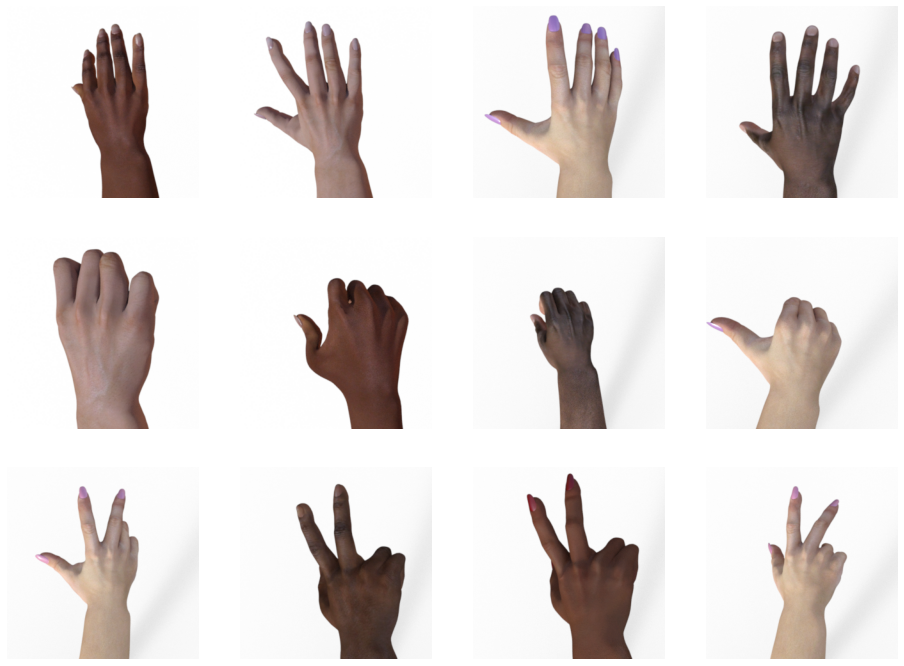

In [14]:
fig, axn = plt.subplots(num_classes, num_images, figsize=(num_images*4, num_classes*4))

for cls_name, row in zip(CLASS_NAMES, axn):
    idx = 0
    for ax in row:
        data_file = DATA_FILES[cls_name][subset][dir_idx + idx]
        img = mpimg.imread(data_file)
        ax.imshow(img)

        ax.grid(False)
        ax.set_axis_off()

        idx += 1


dir_idx += idx



In [15]:
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tfutils.visualize import plot_learning_curve
from sklearn import metrics as skmetrics

## Some Global Variables

In [16]:
TARGET_IMG_SHAPE = (224, 224)
NUM_CHANNELS = 3
INPUT_SHAPE = (*TARGET_IMG_SHAPE, NUM_CHANNELS)
N_CLASSES = 3 
BATCH_SIZE = 128
CLASSIFICATION_TYPE = 'categorical'
OUTPUT_NEURONS = N_CLASSES
RANDOM_STATE = 42
VALIDATION_SPLIT = 0.2

In [17]:
TFMODELS = {}
PREDICTIONS = {'train': {}, 'test': {}}

## Model 1: mobilenet

In [18]:
model_name = 'mobile-net-no-tune'

In [19]:
from tensorflow.keras.applications.mobilenet import MobileNet

pretrained_model = MobileNet(include_top=False, input_shape=INPUT_SHAPE)

for layer in pretrained_model.layers:
    layer.trainable = False

print('Output shape: ', pretrained_model.layers[-1].output_shape)

17227776/17225924 [==============================] - 0s 0us/step
Output shape:  (None, 7, 7, 1024)


In [20]:
inputs = layers.Input(shape=INPUT_SHAPE)
features = pretrained_model(inputs)
pooled = layers.GlobalAveragePooling2D()(features)
x = layers.Dropout(0.2)(pooled)
x = layers.Dense(512)(pooled)
outputs = layers.Dense(OUTPUT_NEURONS, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name=model_name)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])
model.summary()

Model: "mobile-net-no-tune"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 3,755,203
Trainable params: 526,339
Non-trainable params: 3,228,864
_________________________________________________________________


### Preprocess the data


In [21]:
train_datagen = ImageDataGenerator(rescale=1/255., 
                                   rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest',
                                   validation_split=VALIDATION_SPLIT)
validation_datagen = ImageDataGenerator(rescale=1/255., validation_split=VALIDATION_SPLIT)
test_datagen = ImageDataGenerator(rescale=1/255.)

### Setup the directories

In [22]:
train_dir = DATA_DIR['train']
test_dir = DATA_DIR['test']

### Import Data From Directories

In [23]:
train_gen = train_datagen.flow_from_directory(directory=train_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                              subset='training', seed=RANDOM_STATE)
validation_gen = validation_datagen.flow_from_directory(directory=train_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                                   subset='validation', seed=RANDOM_STATE)
test_gen = test_datagen.flow_from_directory(directory=test_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                            shuffle=False)

Found 2016 images belonging to 3 classes.
Found 504 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


### Fit the model

In [24]:
history = model.fit(train_gen, steps_per_epoch=len(train_gen), validation_data=validation_gen, validation_steps=len(validation_gen),
          epochs=10, batch_size=BATCH_SIZE)
TFMODELS[model_name] = model

Epoch 1/10
63/63 [==============================] - 44s 446ms/step - loss: 0.5101 - accuracy: 0.8755 - val_loss: 0.4126 - val_accuracy: 0.8750
Epoch 2/10
63/63 [==============================] - 28s 443ms/step - loss: 0.0297 - accuracy: 0.9901 - val_loss: 0.2319 - val_accuracy: 0.9187
Epoch 3/10
63/63 [==============================] - 27s 423ms/step - loss: 0.0136 - accuracy: 0.9960 - val_loss: 0.0970 - val_accuracy: 0.9623
Epoch 4/10
63/63 [==============================] - 27s 425ms/step - loss: 0.0149 - accuracy: 0.9950 - val_loss: 0.1380 - val_accuracy: 0.9524
Epoch 5/10
63/63 [==============================] - 27s 431ms/step - loss: 0.0067 - accuracy: 0.9995 - val_loss: 0.0806 - val_accuracy: 0.9643
Epoch 6/10
63/63 [==============================] - 26s 418ms/step - loss: 0.0052 - accuracy: 0.9995 - val_loss: 0.1472 - val_accuracy: 0.9524
Epoch 7/10
63/63 [==============================] - 28s 444ms/step - loss: 0.0049 - accuracy: 0.9990 - val_loss: 0.0211 - val_accuracy: 0.9921

### Learning Curve

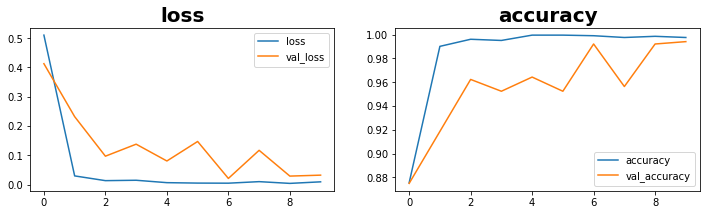

In [25]:
plot_learning_curve(history, extra_metric='accuracy');

### Predictions

In [26]:
for subset in ['train', 'test']:
    PREDICTIONS[subset][model_name] = model.predict(test_gen)

## Performance

In [27]:
from tfutils.evaluate import ClassificationPerformanceComparer

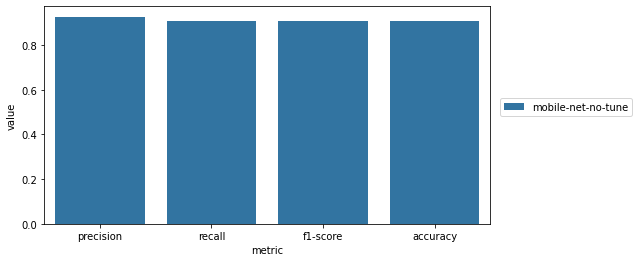

In [28]:

preds = PREDICTIONS['test']
clf_comp = ClassificationPerformanceComparer.from_predictions(predictions=list(preds.values()), data=(None, test_gen.labels),
                                                              model_names=list(preds.keys()), class_names=CLASS_NAMES)
clf_comp.calculate_metric_comparison_df()
clf_comp.plot_metric_comparison_df()